# semantic_analysis.ipynb

Name: Marvin Limpijankit  
Email: ml4431@columbia.edu

This notebook covers the data collection part of this analysis regarding location recognition/classification. Im this notebook, using a pre-trained model from MiT's CSAIL lab (linked below), we will gather location features for each image and export that into a .csv which will be used for semantic_analysis.ipynb later on.    

This notebook was ran on Google Colab to exploit the speeds of GPUs, and relies on there being folders titled, 'US' and 'China' on the same level directory, each containing subfolders containing images from the corresponding news sources, ie. the directory will look something like:   

=====

location_regonition.ipynb  
China  
-> China_Daily  
---> img_0.jpg  
---> img_1.jpg  
---> ...   
-> People's Daily  
-> Xinhua_News_Agency

US  
-> CNN  
-> NBC   
-> NYT

=====

**Note: parts of this notebook involve using tools from third party sources and are heavily adapted from the following sources:**


*   **MiT csail: http://places2.csail.mit.edu**
* https://github.com/ultralytics/yolov5
* https://dev.to/bitproject/extracting-colors-from-images-using-k-means-clustering-3hpe





# Location Recognition: Setup

The following blocks of code are instructions from MiT csail group and are needed to import the neural network for scene recognition. This part of the analysis was done on Google Colab to exploit the GPUs.

### Intro
This notebook shows how to get Caffe with GPU support running in Google Colab. I recommend using the manually compiled version - it gives a lot of power, enables to read, understand and change the framework's code easily.

If you have any problems, please refer [to the medium article](https://filip-drapejkowski.medium.com/caffe-in-google-colab-2021-2d730989c849
) which describes why each steps are necessary and hints how to deal with any future problems.

### GPU setup

### Runtime -> Change Runetime type -> Hardware acccelarator -> GPU

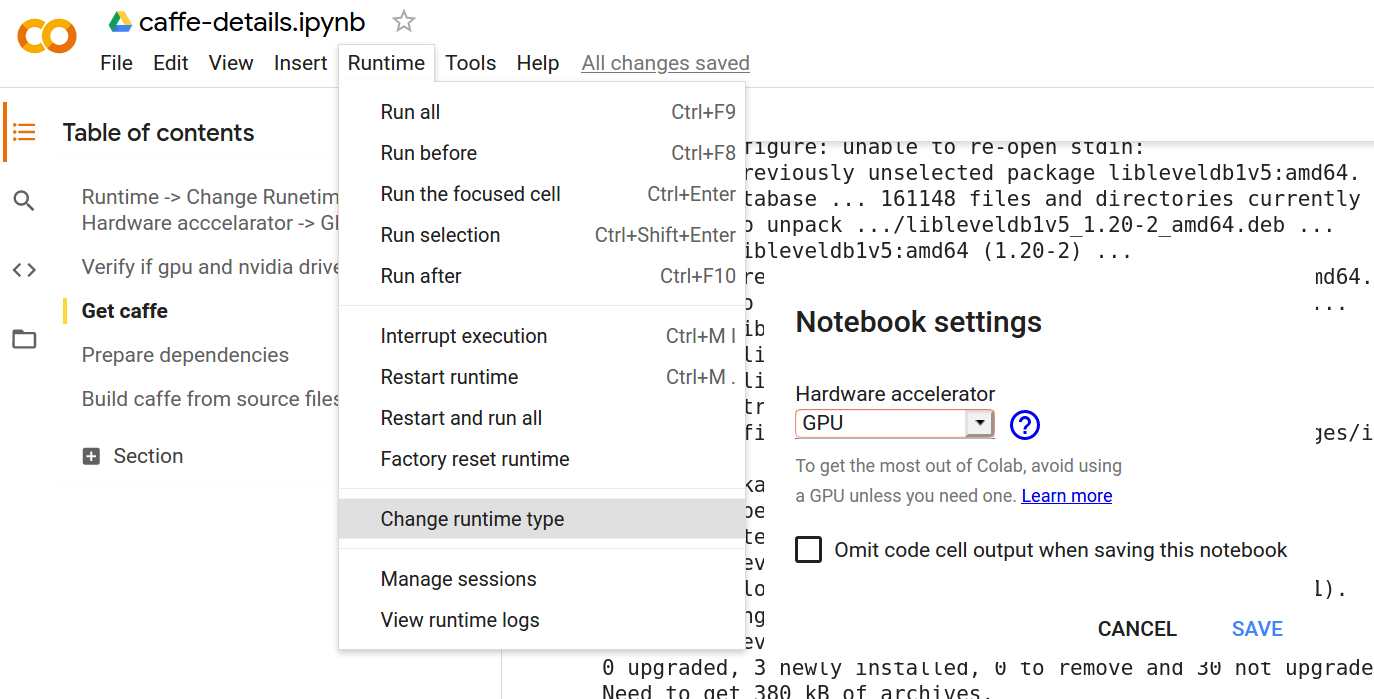

### Verify if gpu and nvidia drivers are present.

In [ ]:
!nvidia-smi

Sun Jul 16 13:43:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get caffe

In [ ]:
!git clone https://github.com/BVLC/caffe.git
!git reset --hard 9b891540183ddc834a02b2bd81b31afae71b2153 #reset to the newest revision that worked OK on 27.03.2021

Cloning into 'caffe'...
remote: Enumerating objects: 65274, done.
remote: Total 65274 (delta 0), reused 0 (delta 0), pack-reused 65274
Receiving objects: 100% (65274/65274), 74.14 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (41242/41242), done.
fatal: not a git repository (or any of the parent directories): .git


### Install Prepare dependencies

In [ ]:
# !sudo apt-cache search libhdf5-
# !sudo apt-cache search gflags
# !sudo apt --fix-broken install
!sudo apt-get install libgflags2.2
!sudo apt-get install libgflags-dev
!sudo apt-get install libgoogle-glog-dev
# !sudo apt-get install libhdf5-10 - replaced with 100
!sudo apt-get install libhdf5-100
!sudo apt-get install libhdf5-serial-dev
!sudo apt-get install libhdf5-dev
# !sudo apt-get install libhdf5-cpp-11 - replaced with 100
!sudo apt-get install libhdf5-cpp-100
!sudo apt-get install libprotobuf-dev protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libgflags2.2
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 78.0 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libgflags2.2 amd64 2.2.2-1build1 [78.0 kB]
Fetched 78.0 kB in 0s (256 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libgflags2.2.
(Reading database ... 123105 files and 

In [ ]:
!find /usr -iname "*hdf5.so"
# got: /usr/lib/x86_64-linux-gnu/hdf5/serial
!find /usr -iname "*hdf5_hl.so"

/usr/lib/x86_64-linux-gnu/hdf5/serial/libhdf5.so
/usr/lib/x86_64-linux-gnu/hdf5/serial/libhdf5_hl.so


In [ ]:
!ln -s /usr/lib/x86_64-linux-gnu/libhdf5_serial.so /usr/lib/x86_64-linux-gnu/libhdf5.so
!ln -s /usr/lib/x86_64-linux-gnu/libhdf5_serial_hl.so /usr/lib/x86_64-linux-gnu/libhdf5_hl.so

In [ ]:
#!find /usr -iname "*hdf5.h*" # got:
# /usr/include/hdf5/serial/hdf5.h
# /usr/include/opencv2/flann/hdf5.h
# Let's try the first one.
%env CPATH="/usr/include/hdf5/serial/"
#fatal error: hdf5.h: No such file or directory

env: CPATH="/usr/include/hdf5/serial/"


In [ ]:
!sudo apt-get install libleveldb-dev
!sudo apt-get install libgflags-dev libgoogle-glog-dev liblmdb-dev
!sudo apt-get install libsnappy-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libleveldb1d
Suggested packages:
  leveldb-doc
The following NEW packages will be installed:
  libleveldb-dev libleveldb1d
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 330 kB of archives.
After this operation, 1,496 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libleveldb1d amd64 1.22-3ubuntu2 [139 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libleveldb-dev amd64 1.22-3ubuntu2 [191 kB]
Fetched 330 kB in 0s (1,065 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This fronte

### Build caffe from source files

In [ ]:
!echo $CPATH

"/usr/include/hdf5/serial/"


In [ ]:
%cd caffe
!ls
!make clean
!cp Makefile.config.example Makefile.config

/content/caffe
caffe.cloc	 data	   INSTALL.md		    models     tools
cmake		 docker    LICENSE		    python
CMakeLists.txt	 docs	   Makefile		    README.md
CONTRIBUTING.md  examples  Makefile.config.example  scripts
CONTRIBUTORS.md  include   matlab		    src
Makefile:6: *** Makefile.config not found. See Makefile.config.example..  Stop.


### Use sed for editing Makefile.config
Just so we don't have to manually open the file with text editor and look where to add the lines below.


In [ ]:
!sed -i 's/-gencode arch=compute_20/#-gencode arch=compute_20/' Makefile.config #old cuda versions won't compile
!sed -i 's/\/usr\/local\/include/\/usr\/local\/include \/usr\/include\/hdf5\/serial\//'  Makefile.config #one of the 4 things needed to fix hdf5 issues
!sed -i 's/# OPENCV_VERSION := 3/OPENCV_VERSION := 3/' Makefile.config #We actually use opencv 4.1.2, but it's similar enough to opencv 3.
!sed -i 's/code=compute_61/code=compute_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_75,code=sm_75 -gencode=arch=compute_75,code=compute_75/' Makefile.config #support for new GPUs

In [ ]:
!make all -j 4 # -j would use all availiable cores, but RAM related errors occur

PROTOC src/caffe/proto/caffe.proto
NVCC src/caffe/layers/cudnn_deconv_layer.cu
NVCC src/caffe/layers/cudnn_lcn_layer.cu
NVCC src/caffe/layers/batch_reindex_layer.cu
NVCC src/caffe/layers/softmax_loss_layer.cu
NVCC src/caffe/layers/recurrent_layer.cu
NVCC src/caffe/layers/mvn_layer.cu
NVCC src/caffe/layers/absval_layer.cu
NVCC src/caffe/layers/dropout_layer.cu
NVCC src/caffe/layers/cudnn_sigmoid_layer.cu
NVCC src/caffe/layers/swish_layer.cu
NVCC src/caffe/layers/sigmoid_layer.cu
NVCC src/caffe/layers/cudnn_conv_layer.cu
NVCC src/caffe/layers/cudnn_relu_layer.cu
NVCC src/caffe/layers/euclidean_loss_layer.cu
NVCC src/caffe/layers/softmax_layer.cu
NVCC src/caffe/layers/elu_layer.cu
NVCC src/caffe/layers/im2col_layer.cu
NVCC src/caffe/layers/inner_product_layer.cu
NVCC src/caffe/layers/hdf5_data_layer.cu
NVCC src/caffe/layers/embed_layer.cu
NVCC src/caffe/layers/log_layer.cu
NVCC src/caffe/layers/cudnn_pooling_layer.cu
NVCC src/caffe/layers/accuracy_layer.cu
NVCC src/caffe/layers/bias_layer

### Verify if caffe works

In [ ]:
import cv2
print(cv2.__version__)
import caffe

4.7.0


In [ ]:
model_def = '/root/machineLearning/deepNeuralNet/caffe/caffemodels/bvlc/caffenet/deploy_changed_net.prototxt'

In [ ]:
%cd ..

/content


In [ ]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

# th architecture to use
arch = 'resnet18'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

In [ ]:
# load the image
img = Image.open('US/CNN/img_0.jpg')
input_img = V(centre_crop(img).unsqueeze(0))

In [ ]:
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

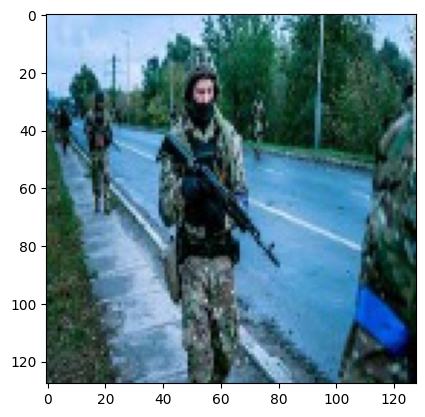

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('US/CNN/img_0.jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
print('{} prediction on {}'.format(arch,'US/CNN/img_0.jpg'))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

resnet18 prediction on US/CNN/img_0.jpg
0.415 -> forest_road
0.192 -> highway
0.079 -> field/wild
0.050 -> rope_bridge
0.027 -> tree_farm


In [ ]:
import numpy as np
 # hacky way to deal with the Pytorch 1.0 update
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)

    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)

    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model


# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

In [ ]:
img = Image.open('US/CNN/img_0.jpg')
input_img = V(centre_crop(img).unsqueeze(0))

In [ ]:
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

print('RESULT ON US/CNN/img_0.jpg')

# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

print(io_image)

# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# output the scene attributes
responses_attribute = W_attribute.dot(features_blobs[1])
idx_a = np.argsort(responses_attribute)
print('--SCENE ATTRIBUTES:')
print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))

# generate class activation mapping
print('Class activation map is saved as cam.jpg')
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

RESULT ON US/CNN/img_0.jpg
--TYPE OF ENVIRONMENT: outdoor
1.0
--SCENE CATEGORIES:
0.542 -> forest_road
0.262 -> highway
0.023 -> ski_slope
0.016 -> desert_road
0.013 -> field_road
--SCENE ATTRIBUTES:
natural light, open area, trees, foliage, man-made, leaves, no horizon, vegetation, biking
Class activation map is saved as cam.jpg


In [ ]:
# render the CAM and output
img = cv2.imread('US/CNN/img_0.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
cv2.imwrite('cam.jpg', result)

True

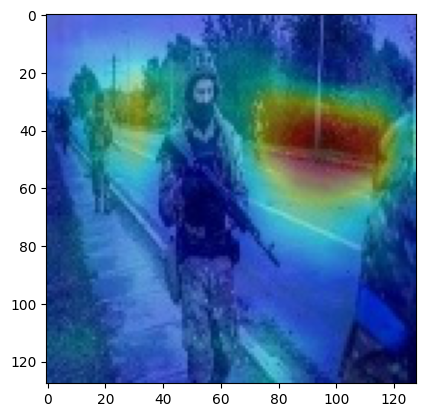

In [ ]:
img = mpimg.imread('cam.jpg')
imgplot = plt.imshow(img)
plt.show()

# Extract Semantic Image Data (Location)

In this section, we extract the semantic information (location) from the images. We use two metrics:

1) I/O scoring, a 0-1 integer representing how indoor/outdoor the location of the image appears

2) location, a softmaax array with probabilities that each image corresponds to each of the available location labels (see 'classes')

In [ ]:
# load the class labels
# - classes, an ordered array containing the names (string) of all location classes (provides a mapping from index to actual labels)

file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

In [ ]:
# load indoor/outdoor information associated with each location
# - labels_IO, a one-hot encoded array denoting if each location (corresponding to classes) is indoor or outdoor

file_name_IO = 'IO_places365.txt'
if not os.access(file_name_IO, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
    os.system('wget ' + synset_url)
with open(file_name_IO) as f:
    lines = f.readlines()
    labels_IO = []
    for line in lines:
        items = line.rstrip().split()
        labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
labels_IO = np.array(labels_IO)

In [ ]:
"""
get_scenes:

--> Given images organized into folders by source, use a NN generate location labels

--> Inputs:
-

--> Outputs:
- io_scoring, a dictionary with source names (ie. 'CNN') as keys and tuples (img_name, io_score) as values where io_score is a 0-1 value denoting how indoor/outdoor the image is
- locations_dict, a dictionary with sources names (ie. 'CNN') as keys and tuples (img_name, probs) as values where probs is an array with the probability of each location corresponding to 'classes'
"""

def get_scenes():

  # list with all the websites
  websites = [('CNN', 'US'), ('NBC', 'US'), ('NYT', 'US'), ('China_Daily', 'China'),
            ('People\'s_Daily', 'China'), ('Xinhua_News_Agency', 'China')]

  # dictionaries to store output
  io_scoring = {}
  locations_dict = {}

  # iterate through websites
  for website in websites:

    # build the path
    website_path = '/content/{}/{}'.format(website[1], website[0])

    # temporary lists to store data for a single image
    io_scores = []
    locations = []

    # iterate through images
    for file in os.listdir(website_path):
        filename = os.fsdecode(file)
        if(filename[-4:] == '.jpg'):

            # open the image, and pass it through the NN
            img = Image.open('{}/{}'.format(website_path, filename))
            input_img = V(centre_crop(img).unsqueeze(0))

            logit = model.forward(input_img)
            h_x = F.softmax(logit, 1).data.squeeze()
            probs = h_x.numpy()

            # update the data for each image
            io_image = np.sum(probs*labels_IO)
            io_scores.append((filename, io_image))
            locations.append((filename, probs))

            # render the CAM image (for interpretability)
            _, idx = h_x.sort(0, True)
            idx = idx.numpy()
            CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
            img = cv2.imread('{}/{}'.format(website_path, filename))
            height, width, _ = img.shape
            heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
            result = heatmap * 0.4 + img * 0.5
            cv2.imwrite('/content/cams/{}/{}_cams.jpg'.format(website[0], filename), result)

    # update the data for each source
    io_scoring[website[0]] = io_scores
    locations_dict[website[0]] = locations

  # return output
  return io_scoring, locations_dict

io_scoring, locations = get_scenes()

In [ ]:
from google.colab import files

# save the data
np.save('/content/classes.npy', classes)
np.save('/content/io_scoring.npy', io_scoring)
np.save('/content/locations.npy', locations)

# download the files
files.download("/content/io_scoring.npy")
files.download("/content/locations.npy")
files.download("/content/classes.npy")

# load the data from the files
classes = np.load('/content/classes.npy')

io_scoring = np.load('/content/io_scoring.npy', allow_pickle=True)
io_scoring = io_scoring.item()

locations = np.load('/content/locations.npy', allow_pickle=True)
locations = locations.item()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from the io_scoring dictionary convert the data into a workable dataframe

# 2D list to be turned into a dataframe
out = []

# column names
headers = ['source', 'image', 'indoor/outdoor score']

# iterate through sources
for source in io_scoring.keys():

  # iterate through images
  for img in io_scoring[source]:
    out.append([source, img[0], img[1]])

df = pd.DataFrame(out, columns=headers)
df.head(10)

# export the results
df.to_csv('io_scoring.csv', index=False)

In [ ]:
# from the locations dictionary convert the data into a workable dataframe

# 2D list to be turned into a dataframe
out = []

# column names
headers = ['source', 'image'] + list(classes)

# iterate through sources
for source in locations.keys():

  # iterate through images
  for img in locations[source]:
    out.append([source, img[0]] + list(img[1]))

df = pd.DataFrame(out, columns=headers)
df.head(10)

# export the results
df.to_csv('locations.csv', index=False)

# Analyze Image Data (Location)

In this section, we analyze the data collected from the previous section and compare the differences between images from different news sources.

### Word Clouds

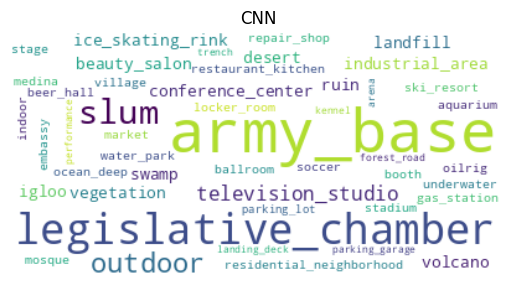

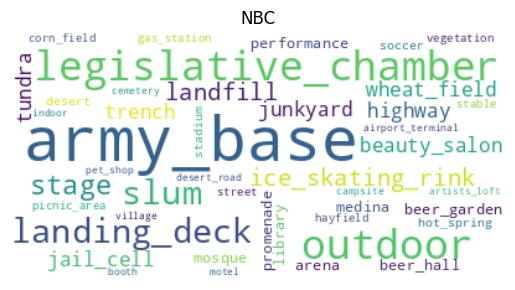

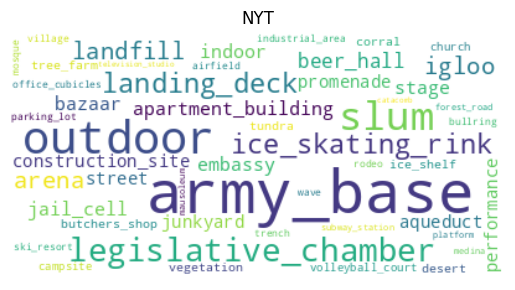

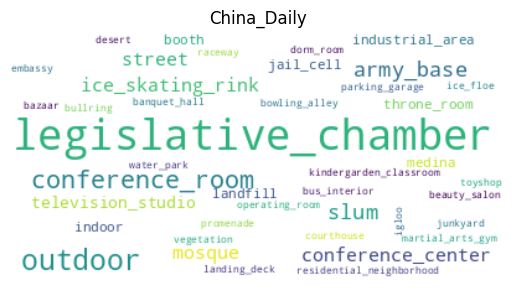

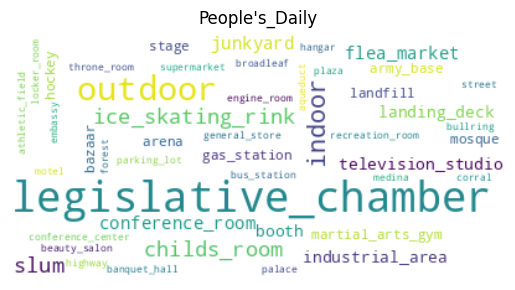

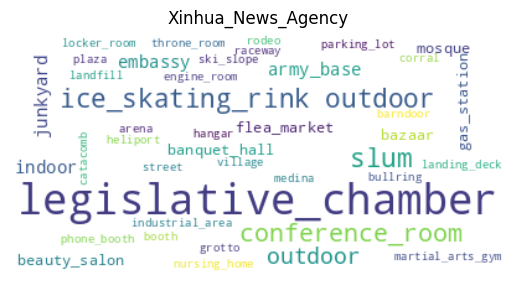

In [ ]:
from wordcloud import WordCloud

# iterate through each source
for website in locations.keys():

  tmp_locations = []

  for tup in locations[website]:

    # get the predicted location of the image
    top_idx = np.argmax(tup[1])
    tmp_locations.append(classes[top_idx])

  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(tmp_locations))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(website)
  plt.savefig('/content/word_cloud/{}_wordcloud.jpg'.format(website))

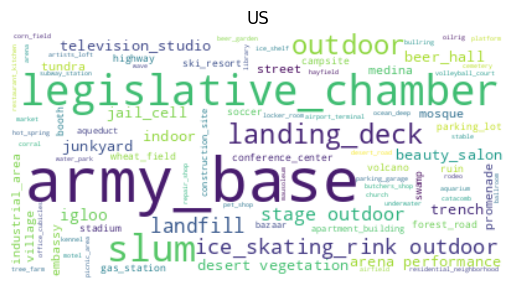

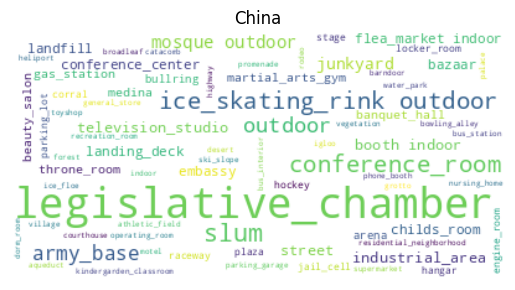

In [ ]:
# Word Clouds by region

# iterate through each source
for source in [('US', ['CNN', 'NBC', 'NYT']), ('China', ['China_Daily', 'People\'s_Daily', 'Xinhua_News_Agency'])]:

  tmp_locations = []

  for website in source[1]:

    for tup in locations[website]:

      # get the predicted location of the image
      top_idx = np.argmax(tup[1])
      tmp_locations.append(classes[top_idx])

  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(tmp_locations))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(source[0])
  plt.savefig('/content/word_cloud/{}_wordcloud.jpg'.format(source[0]))

### Indoor/Outdoor Scores

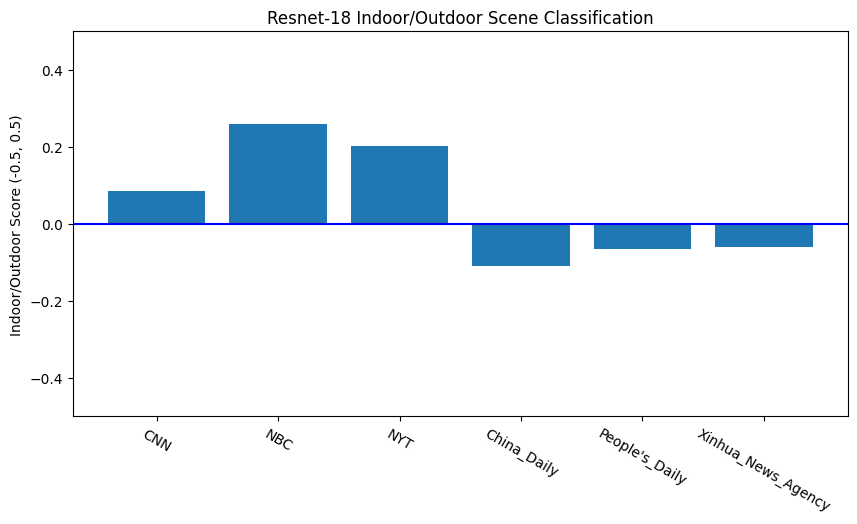

In [ ]:
# compare indoor/outdoor score by source, shifted from the range 0 - 1 to -0.5 - 0.5

# gather the average indoor/outdoor score for each source
labels = []
data = []

for key in io_scoring.keys():

  io_scores = [i[1] for i in io_scoring[key]]

  labels.append(key)
  data.append(np.mean(io_scores))

# plot the results
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, [i-0.5 for i in data])
plt.ylim(-0.5, 0.5)
plt.ylabel('Indoor/Outdoor Score (-0.5, 0.5)')
plt.title('Resnet-18 Indoor/Outdoor Scene Classification')
plt.xticks(rotation=-30)
plt.axhline(y=0, color='b', linestyle='-')

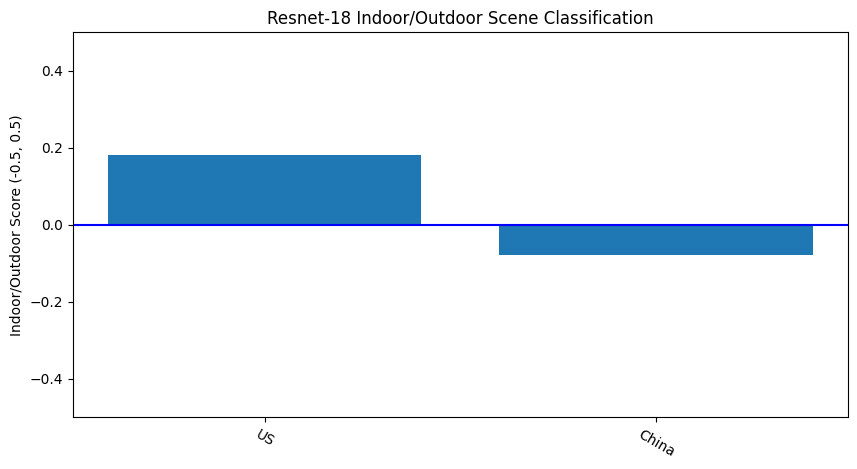

In [ ]:
# compare indoor/outdoor score by region, shifted from the range 0 - 1 to -0.5 - 0.5

# gather the average indoor/outdoor score for each region
labels = ['US', 'China']

us_scores = []
china_scores = []
data = []

for source in ['CNN', 'NBC', 'NYT']:

  io_scores = [i[1] for i in io_scoring[source]]
  us_scores += io_scores

for source in ['China_Daily', 'People\'s_Daily', 'Xinhua_News_Agency']:

  io_scores = [i[1] for i in io_scoring[source]]
  china_scores += io_scores

data.append(np.mean(us_scores))
data.append(np.mean(china_scores))

# plot the results
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, [i-0.5 for i in data])
plt.ylim(-0.5, 0.5)
plt.ylabel('Indoor/Outdoor Score (-0.5, 0.5)')
plt.title('Resnet-18 Indoor/Outdoor Scene Classification')
plt.xticks(rotation=-30)
plt.axhline(y=0, color='b', linestyle='-')

### PCA Analysis

In this section, we run PCA using the scene predictions to find which scenes are most important when considering the variability of the images. First, we translate the existing dictionary into a workable dataframe, then we apply PCA to reduce these dimensions and see which locations provide us the most information about the images in the dataset.  

In [ ]:
import pandas as pd

# 2D list to be turned into a dataframe
out = []

# column names
headers = ['source', 'image'] + list(classes)

# iterate through sources
for source in locations.keys():

  # iterate through images
  for img_tuple in locations[source]:

    # collect variables to populate the rows in our dataframe
    source_name = source
    img_name = img_tuple[0]
    data = img_tuple[1]

    row = [source, img_name] + list(data)

    out.append(row)

df = pd.DataFrame(out, columns=headers)
df.head(10)

source       image      airfield  airplane_cabin  airport_terminal  \
0    CNN  img_47.jpg  1.115593e-03    1.147636e-03      1.183769e-03   
1    CNN  img_48.jpg  1.895663e-07    5.407404e-07      1.986749e-07   
2    CNN  img_70.jpg  5.514170e-06    1.169717e-04      1.274219e-04   
3    CNN  img_92.jpg  1.081991e-04    2.671538e-05      8.379426e-05   
4    CNN  img_59.jpg  4.492674e-05    1.467569e-04      2.010632e-05   
5    CNN  img_31.jpg  6.200086e-04    7.424216e-03      1.085313e-03   
6    CNN  img_49.jpg  7.320395e-05    1.178773e-04      1.750912e-04   
7    CNN   img_3.jpg  1.550373e-06    7.094892e-05      8.956578e-05   
8    CNN  img_73.jpg  5.280894e-04    4.028031e-04      1.705001e-04   
9    CNN  img_38.jpg  4.430889e-03    2.243159e-04      2.551447e-04   

         alcove         alley  amphitheater  amusement_arcade  amusement_park  \
0  4.489752e-04  1.116732e-04  1.455706e-04      6.421963e-04    3.532594e-04   
1  1.567573e-08  5.367841e-09  1.197237e-07      6.275478e-08    5.795561e-08   
2  3.267344e-05  1.555335e-05  6.582895e-06      1.026196e-04    5.286805e-05   
3  2.925248e-03  4.948239e-04  1.592252e-02      1.330680e-05    3.280714e-04   
4  2.484241e-05  3.459742e-06  6.303880e-05      1.480541e-05    9.046695e-06   
5  5.940803e-04  2.397800e-04  7.399854e-04      7.700885e-04    4.257061e-04   
6  4.365550e-03  9.627701e-03  5.181333e-03      4.072723e-05    4.978799e-04   
7  7.759914e-06  6.593892e-06  2.199095e-04      1.229041e-04    2.074002e-04   
8  6.491173e-03  3.854349e-03  4.264693e-02      2.016896e-05    5.076266e-04   
9  6.439227e-04  1.897556e-04  3.166788e-04      1.604002e-04    3.027436e-03   

   ...     waterfall  watering_hole          wave       wet_bar   wheat_field  \
0  ...  1.279421e-05   1.486867e-04  1.671947e-05  4.844199e-05  2.319691e-05   
1  ...  1.250040e-09   1.473778e-08  2.631509e-10  7.513410e-09  3.716203e-09   
2  ...  3.438798e-07   1.226168e-05  1.399052e-07  1.159583e-05  7.531042e-06   
3  ...  7.324546e-04   3.592267e-03  7.390531e-04  5.729483e-05  1.201332e-04   
4  ...  2.226946e-06   3.891074e-05  5.936972e-07  1.041883e-05  2.936968e-06   
5  ...  1.554963e-04   1.891559e-03  7.830503e-05  5.605735e-04  4.029138e-04   
6  ...  7.786540e-04   6.222327e-03  1.082221e-03  7.169016e-04  1.236407e-04   
7  ...  6.810796e-07   7.722278e-06  6.678184e-07  1.837321e-05  4.912974e-07   
8  ...  1.980696e-04   4.213382e-03  2.810938e-04  2.010213e-04  1.919466e-05   
9  ...  1.527247e-03   3.006023e-03  3.372053e-04  6.455112e-05  6.645462e-04   

      wind_farm      windmill          yard  youth_hostel    zen_garden  
0  1.940108e-05  2.187664e-05  1.411800e-05  3.552703e-04  8.051110e-05  
1  7.252805e-09  5.196938e-09  1.583203e-09  5.373742e-09  2.229313e-08  
2  2.396255e-06  4.604099e-06  7.910273e-07  4.478446e-06  1.751214e-06  
3  6.858094e-05  1.557169e-04  3.210487e-04  2.117937e-05  3.774356e-03  
4  4.783810e-06  5.646046e-06  8.338436e-06  2.728827e-05  1.655356e-04  
5  3.618022e-05  6.709273e-05  1.495028e-04  2.707455e-04  5.833380e-04  
6  1.105961e-04  1.253987e-04  7.829636e-04  1.756495e-04  1.627194e-03  
7  5.447239e-07  2.183310e-06  6.050627e-07  1.199046e-05  4.806285e-06  
8  3.413787e-05  2.092838e-04  8.555863e-05  2.409484e-05  3.416453e-04  
9  7.119215e-05  1.523478e-04  4.901472e-04  8.550230e-05  7.811486e-04  

[10 rows x 367 columns]

Text(0.5, 1.0, 'PCA Results For Location Features (red=Western, blue=Chinese')

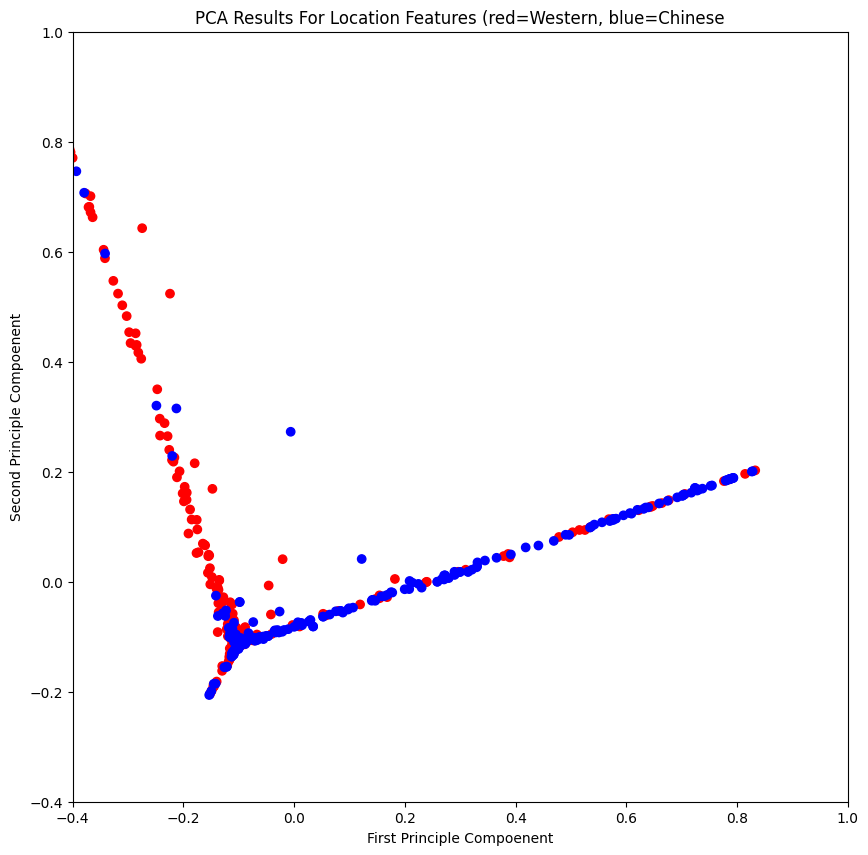

In [ ]:
# apply PCA (Principle Component Analysis)
from sklearn.decomposition import PCA
import plotly.express as px

# packages work with 2D numpy arrays
out = df.to_numpy()

pca = PCA(n_components=2)

# first two columns are filename, source
X_pca = pca.fit_transform(out[:,2:])

# encoding region, 0 indicates Western Source (red), 1 indicates Chinese sources (blue)
y = [0 if i in ['CNN', 'NBC', 'NYT'] else 1 for i in out[:,0]]
cdict = {0: 'red', 1: 'blue'}

# plot the results
plt.figure(figsize=(10,10))
ax = plt.scatter(X_pca[:, 0], y=X_pca[:, 1], c = [cdict[i] for i in y])
plt.xlim(-0.4, 1)
plt.ylim(-0.4, 1)
plt.xlabel('First Principle Compoenent')
plt.ylabel('Second Principle Compoenent')
plt.title('PCA Results For Location Features (red=Western, blue=Chinese')

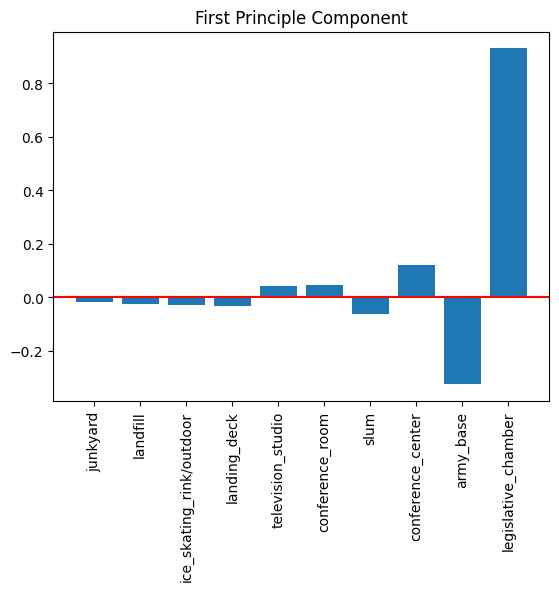

In [ ]:
# examine the components of PCA

# order the features contributing to the component by absolute value
res = sorted(zip(classes, (pca.components_[0])), key = lambda x: abs(x[1]))

# only plot the top 10 features
k = 10

# plot the result
labels = [i[0] for i in res[-k:]]
vals = [i[1] for i in res[-k:]]
plt.bar(labels, vals)
plt.title('First Principle Component')
plt.xticks(rotation='vertical')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

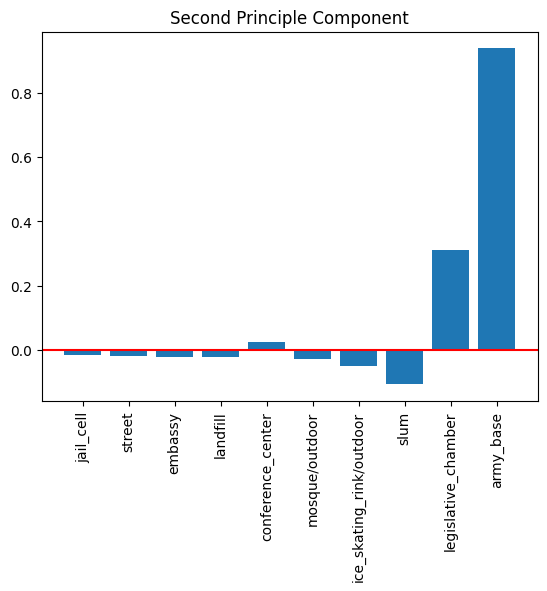

In [ ]:
# examine the components of PCA

# order the features contributing to the component by absolute value
res = sorted(zip(classes, (pca.components_[1])), key = lambda x: abs(x[1]))

# only plot the top 10 features
k = 10

# plot the result
labels = [i[0] for i in res[-k:]]
vals = [i[1] for i in res[-k:]]
plt.bar(labels, vals)
plt.title('Second Principle Component')
plt.xticks(rotation='vertical')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Text(0.5, 1.0, 'Legislative_chamber vs. Army_base (red=Western, blue=Chinese)')

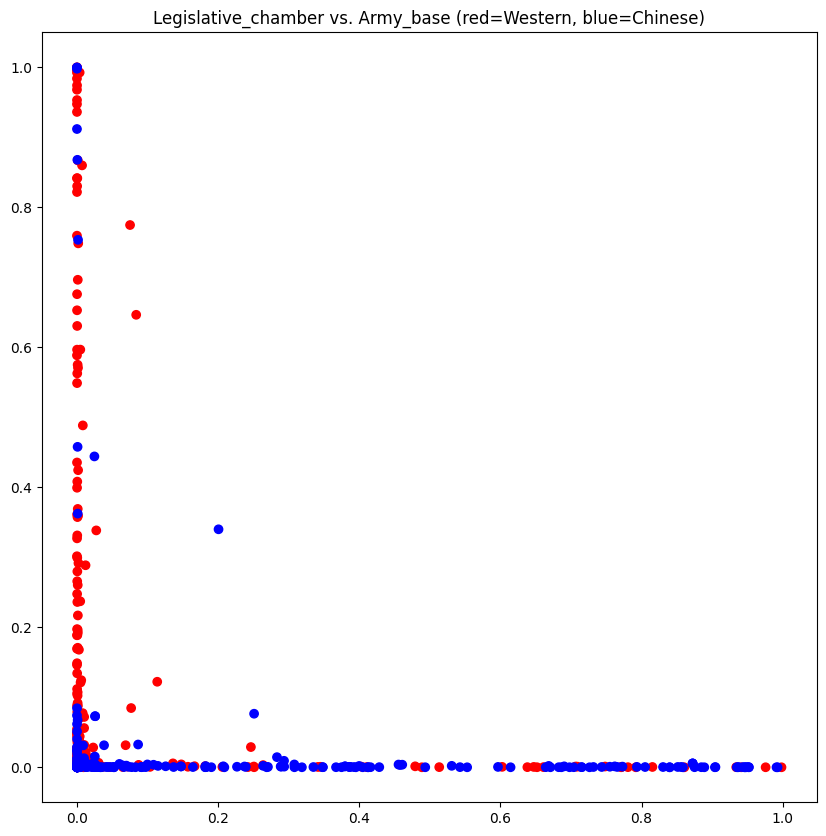

In [ ]:
# replot the data points in 2D only using 'legislative_chamber' and 'army_base' features

# extract the necessary features
x = df['legislative_chamber'].values
y = df['army_base'].values
c = [cdict[i] for i in [0 if i in ['CNN', 'NBC', 'NYT'] else 1 for i in out[:,0]]]

# plot the results
plt.figure(figsize=(10,10))
plt.scatter(x, y, c=c)
plt.title('Legislative_chamber vs. Army_base (red=Western, blue=Chinese)')

### Hierarchical Agg Clustering of Location Features

In this section, we attempt to cluster the images by their location feature vectors to investigate any clusterings of images that may emerge, and see whether images from sources tend to gravitate towards certain clusters or not.

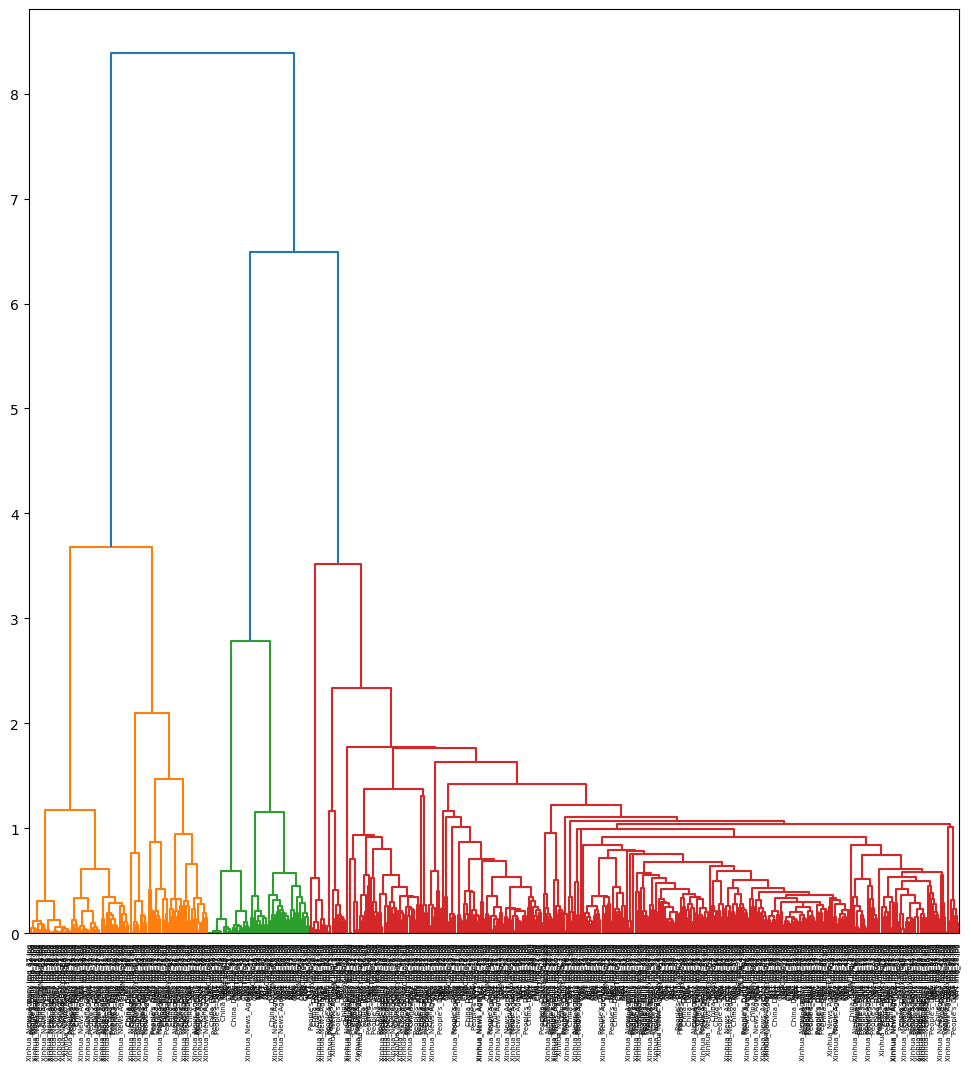

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# define the linkage
linkage_data = linkage(out[:,2:], method='ward', metric='euclidean')

# plot the resulting dendrogram
fig = plt.figure(figsize=(12, 12))
clustering = dendrogram(linkage_data, labels=out[:,0]+' '+out[:,1])
plt.show()

In [ ]:
# examine the source distribution among the resulting clusters more carefully

# get the indices of each where each cluster starts
c2_ind = clustering['leaves_color_list'].index('C2')
c3_ind = clustering['leaves_color_list'].index('C3')

# split the images into clusters (1: orange, 2: green, 3: red)
group_1_imgs = clustering['ivl'][:c2_ind]
group_2_imgs = clustering['ivl'][c2_ind:c3_ind]
group_3_imgs = clustering['ivl'][c3_ind:]

# labels
labels = {'CNN': 'CNN',
          'NYT': 'NYT',
          'NBC': 'NBC',
          'Chi': 'China_Daily',
          'Xin': 'Xinhua_News_Agency',
          'Peo': 'People\'s Daily'}

# iterate through each cluster, printing the distribution among them
for ind, group in enumerate([group_1_imgs, group_2_imgs, group_3_imgs]):

  print('Statics for group: {}'.format(ind+1))

  tmp_list = [labels[i[:3]] for i in group]

  cnn = tmp_list.count('CNN')
  nyt = tmp_list.count('NYT')
  nbc = tmp_list.count('NBC')
  china_daily = tmp_list.count('China_Daily')
  xinhua_news_agency = tmp_list.count('Xinhua_News_Agency')
  peoples_daily = tmp_list.count('People\'s Daily')

  # print the results
  print('\n')

  print('Western: {:0.2f}% ({} total)'.format(100*(cnn+nyt+nbc)/len(group), (cnn+nyt+nbc)))
  print('\t - CNN: {}'.format(cnn))
  print('\t - NYT: {}'.format(nyt))
  print('\t - NBC: {}'.format(nbc))

  print('\n')

  print('Chinese: {:0.2f}% ({} total)'.format(100*(china_daily+xinhua_news_agency+peoples_daily)/len(group), (china_daily+xinhua_news_agency+peoples_daily)))
  print('\t - China_Daily: {}'.format(china_daily))
  print('\t - Xinhua_News_Agency: {}'.format(xinhua_news_agency))
  print('\t - People\'s_Daily: {}'.format(peoples_daily))

  print('\n')

Statics for group: 1


Western: 26.32% (30 total)
	 - CNN: 19
	 - NYT: 6
	 - NBC: 5


Chinese: 73.68% (84 total)
	 - China_Daily: 34
	 - Xinhua_News_Agency: 29
	 - People's_Daily: 21


Statics for group: 2


Western: 86.15% (56 total)
	 - CNN: 17
	 - NYT: 16
	 - NBC: 23


Chinese: 13.85% (9 total)
	 - China_Daily: 4
	 - Xinhua_News_Agency: 3
	 - People's_Daily: 2


Statics for group: 3


Western: 50.97% (211 total)
	 - CNN: 63
	 - NYT: 77
	 - NBC: 71


Chinese: 49.03% (203 total)
	 - China_Daily: 61
	 - Xinhua_News_Agency: 66
	 - People's_Daily: 76




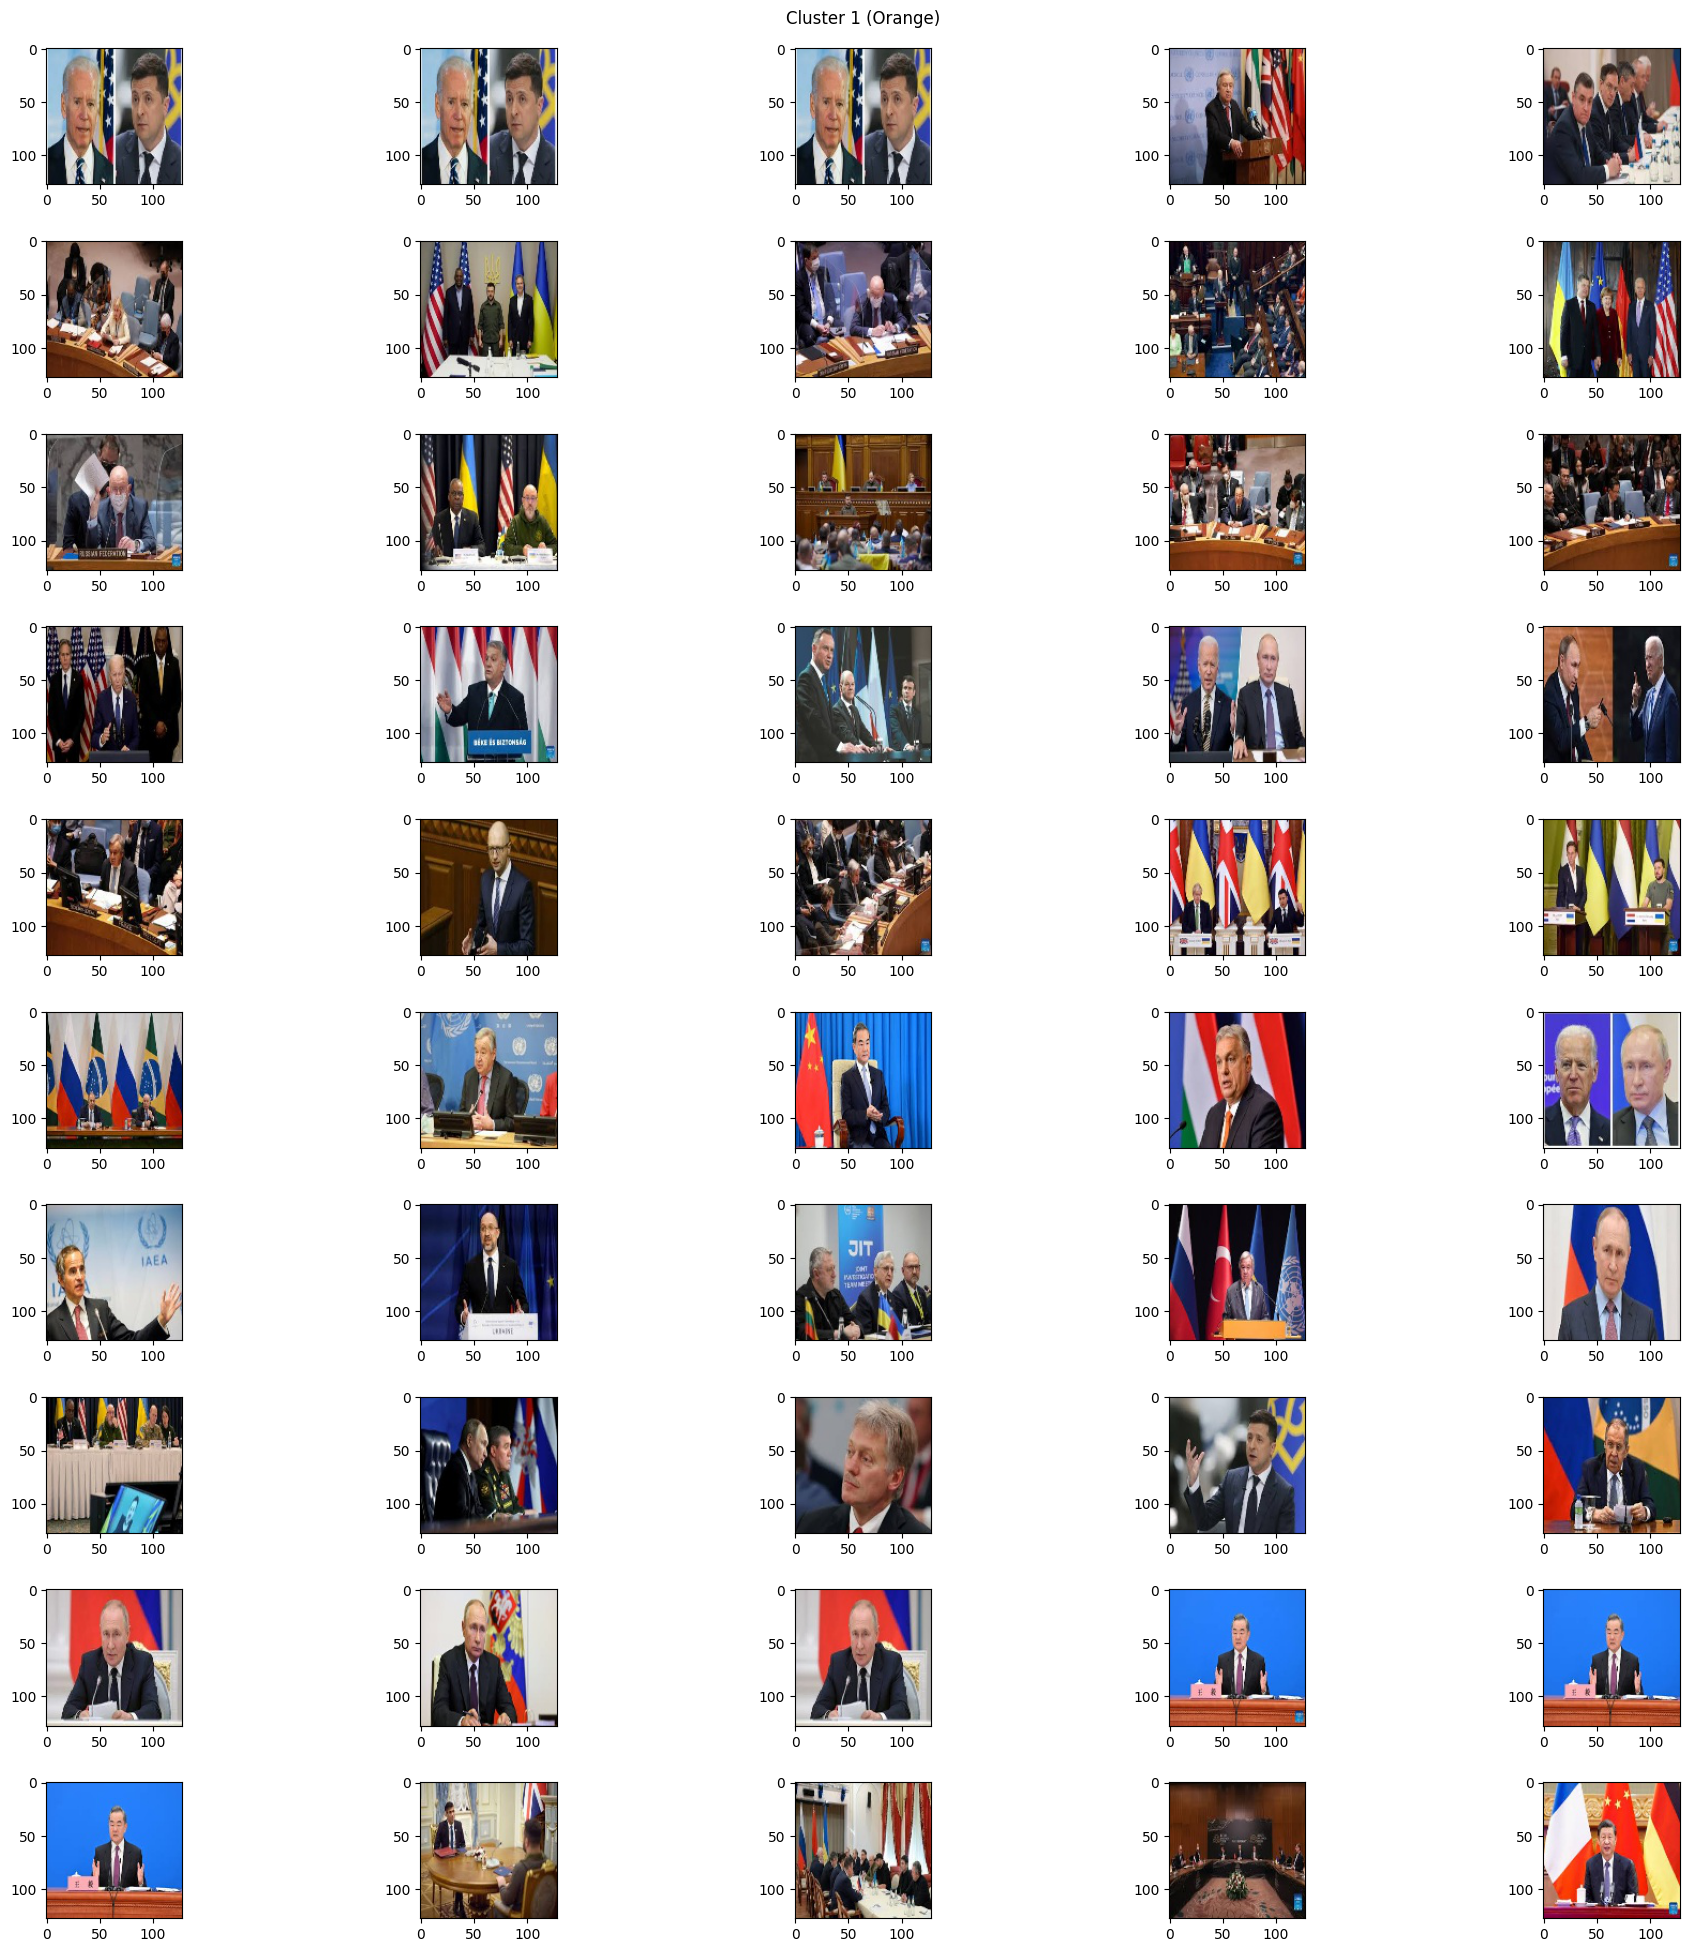

In [ ]:
# qualitatively evaluate cluster 1 (orange) by visualizing some sample images from that cluster

f, axarr = plt.subplots(10,5, figsize=(20,20))

# mapping source to region
website_dict_tmp = {'China_Daily': 'China',
                    'People\'s_Daily': 'China',
                    'Xinhua_News_Agency': 'China',
                    'CNN': 'US',
                    'NBC': 'US',
                    'NYT': 'US'}

# iterate through images in the cluster
for i, img_name in enumerate(group_1_imgs):

  # only plot the first 50
  if i >= 50:
    break

  # collect metadata
  image_source = img_name.split(" ")[0]
  image_filename = img_name.split(" ")[1]
  country = website_dict_tmp[image_source]

  # plot
  axarr[i//5,i%5].imshow(plt.imread('./{}/{}/{}'.format(country, image_source, image_filename)))

f.suptitle('Cluster 1 (Orange)')
plt.tight_layout(pad = 2)

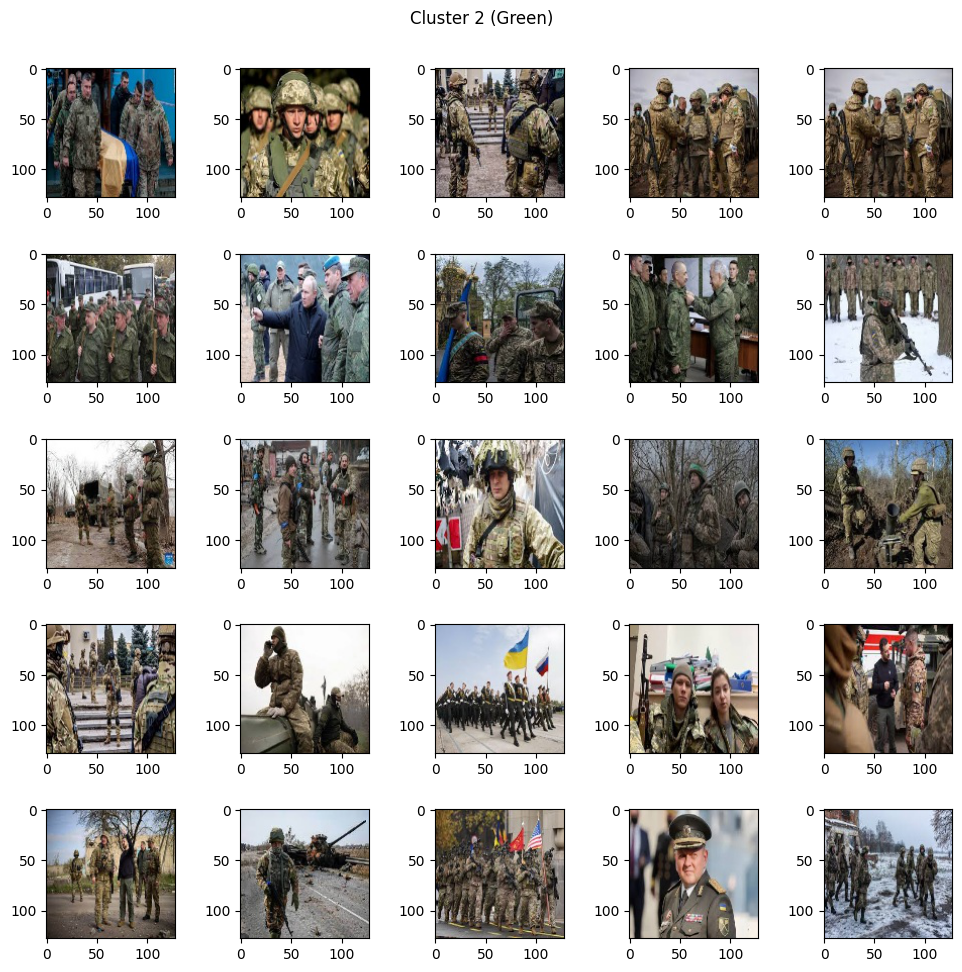

In [ ]:
# qualitatively evaluate cluster 2 (green) by visualizing some sample images from that cluster

f, axarr = plt.subplots(5,5, figsize=(10,10))

# mapping source to region
website_dict_tmp = {'China_Daily': 'China',
                    'People\'s_Daily': 'China',
                    'Xinhua_News_Agency': 'China',
                    'CNN': 'US',
                    'NBC': 'US',
                    'NYT': 'US'}

# iterate through images in the cluster
for i, img_name in enumerate(group_2_imgs):

  # only plot the first 50
  if i >= 25:
    break

  # collect metadata
  image_source = img_name.split(" ")[0]
  image_filename = img_name.split(" ")[1]
  country = website_dict_tmp[image_source]

  # plot
  axarr[i//5,i%5].imshow(plt.imread('./{}/{}/{}'.format(country, image_source, image_filename)))

f.suptitle('Cluster 2 (Green)')
plt.tight_layout(pad = 2)

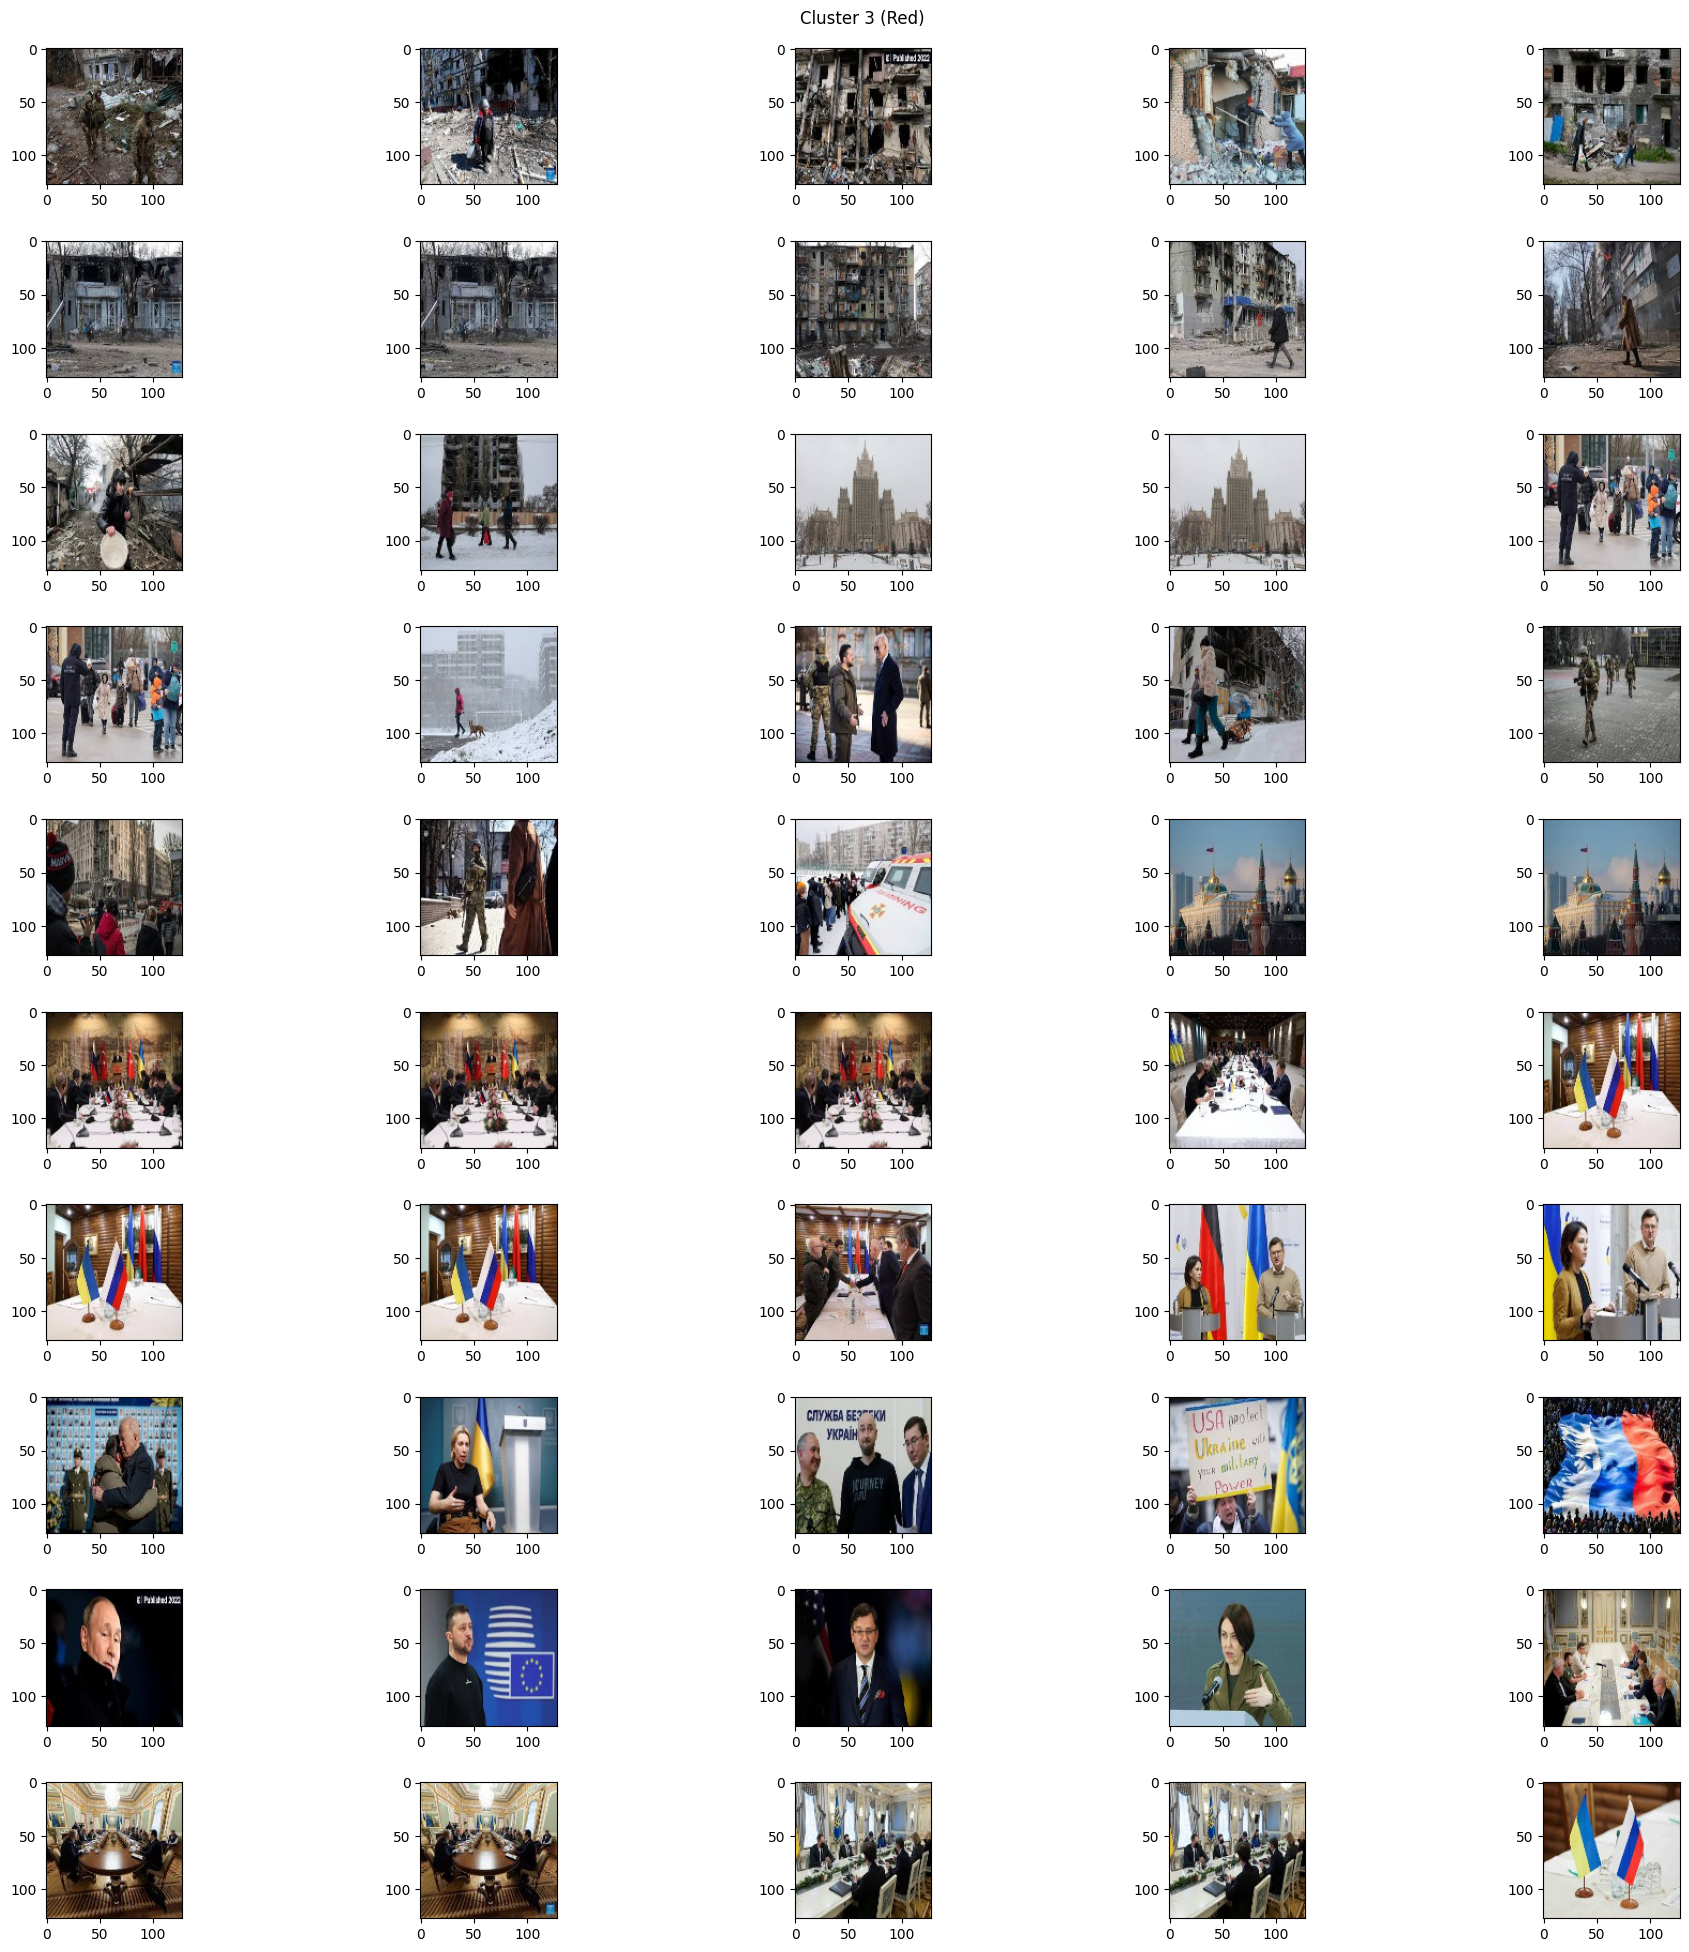

In [ ]:
# qualitatively evaluate cluster 3 (red) by visualizing some sample images from that cluster

f, axarr = plt.subplots(10,5, figsize=(20,20))

# mapping source to region
website_dict_tmp = {'China_Daily': 'China',
                    'People\'s_Daily': 'China',
                    'Xinhua_News_Agency': 'China',
                    'CNN': 'US',
                    'NBC': 'US',
                    'NYT': 'US'}

# iterate through images in the cluster
for i, img_name in enumerate(group_3_imgs):

  # only plot the first 50
  if i >= 50:
    break

  # collect metadata
  image_source = img_name.split(" ")[0]
  image_filename = img_name.split(" ")[1]
  country = website_dict_tmp[image_source]

  # plot
  axarr[i//5,i%5].imshow(plt.imread('./{}/{}/{}'.format(country, image_source, image_filename)))

f.suptitle('Cluster 3 (Red)')
plt.tight_layout(pad = 2)

### K-Means Clustering: Extracting Color Palettes

Here, we experiment with K-means, an unsupervised learning technique, on the RGB space of images to extract clusters representing 'dominant' colors ie. color palettes.

Source: https://dev.to/bitproject/extracting-colors-from-images-using-k-means-clustering-3hpe

In [ ]:
# Source: https://dev.to/bitproject/extracting-colors-from-images-using-k-means-clustering-3hpe

# create the bar to display color palette
def create_bar(height, width, color):
    bar = np.zeros((height, width, 3), np.uint8)
    bar[:] = color
    red, green, blue = int(color[2]), int(color[1]), int(color[0])
    return bar, (red, green, blue)

# extract the color palette on a sample image
img = cv2.imread('./US/NYT/img_19.jpg')
height, width, _ = np.shape(img)

data = np.reshape(img, (height * width, 3))
data = np.float32(data)

number_clusters = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(data, number_clusters, None, criteria, 10, flags)

font = cv2.FONT_HERSHEY_SIMPLEX
bars = []
rgb_values = []

for index, row in enumerate(centers):
    bar, rgb = create_bar(200, 200, row)
    bars.append(bar)
    rgb_values.append(rgb)

img_bar = np.hstack(bars)

for index, row in enumerate(rgb_values):
    image = cv2.putText(img_bar, f'{index + 1}. RGB: {row}', (5 + 200 * index, 200 - 10),
                        font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    print(f'{index + 1}. RGB{row}')



1. RGB(68, 58, 49)
2. RGB(198, 192, 189)
3. RGB(161, 158, 153)
4. RGB(14, 9, 5)
5. RGB(175, 174, 170)
6. RGB(141, 129, 117)
7. RGB(201, 183, 102)
8. RGB(86, 76, 68)
9. RGB(43, 35, 27)
10. RGB(113, 101, 90)


Text(0.5, 1.0, 'Sample image from NYT')

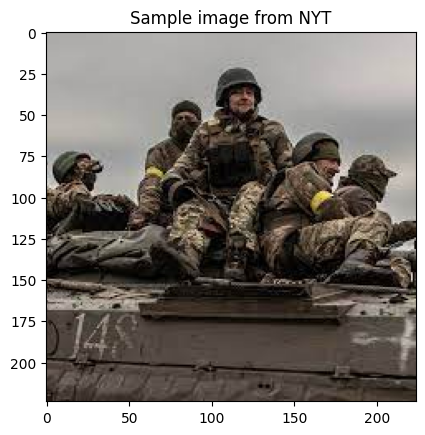

In [ ]:
# plot the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Sample image from NYT')

Text(0.5, 1.0, 'Sample extracted palette using K-means clustering')

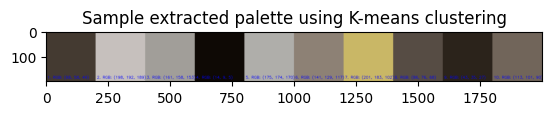

In [ ]:
# plot the palette
plt.imshow(cv2.cvtColor(img_bar, cv2.COLOR_BGR2RGB))
plt.title('Sample extracted palette using K-means clustering')

# Extract Semantic Image Data (Object Recognition)

In this section we extract more image data in the form of object recognition, more specifically using a NN to detect how many people are present in each image.

### Setup

Importing the NN (Yolov5 model) to do object detection.

In [ ]:
# install dependencies/models
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

import torch
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use

In [ ]:
# run the model on a sample image
images = './US/NYT/images-19.jpg'
results = model(images)
results.print()
results.pandas().xyxy[0]

image 1/1: 168x299 1 person, 2 backpacks, 1 kite
Speed: 64.8ms pre-process, 211.4ms inference, 52.9ms NMS per image at shape (1, 3, 384, 640)


xmin        ymin        xmax        ymax  confidence  class      name
0  114.790504  113.092995  189.792725  168.000000    0.841549      0    person
1  110.362358   21.705482  184.080017  127.147377    0.614048     33      kite
2  131.552612  138.495514  162.240479  167.857513    0.481198     24  backpack
3  114.824654  111.359726  190.597397  168.000000    0.289568     24  backpack

### Extract Data From Images

In [ ]:
# dictionary to store the number of people per image
people_count = {'CNN': [],
                'NBC': [],
                'NYT': [],
                'China_Daily': [],
                'People\'s_Daily': [],
                'Xinhua_News_Agency': []}

# regions
countries = ['US', 'China']

# sources
websites = {'US': ['CNN', 'NBC', 'NYT'],
           'China': ['China_Daily', 'People\'s_Daily', 'Xinhua_News_Agency']}

# iterate through each region
for country in countries:

  # iterate through each source
  for website in websites[country]:

    # get filenames
    files = os.listdir('./{}/{}'.format(country, website))
    files.remove('.DS_Store')
    images = ['./'+country+'/'+website+'/'+i for i in files]

    # pass the image through the network in a batch
    results = model(images)

    # iterate through
    for i in range(len(files)):

      # update the data
      df = results.pandas().xyxy[i]
      people_count[website].append((files[i], len(df[df['name']=='person'])))

In [ ]:
# from the dictionary convert the data into a workable dataframe

# 2D list to be turned into a dataframe
out = []

# column names
headers = ['source', 'image', 'people_count']

# iterate through sources
for source in people_count.keys():

  # iterate through images
  for num_people in people_count[source]:
    out.append([source, num_people[0], num_people[1]])

df = pd.DataFrame(out, columns=headers)
df.head(10)

df.to_csv('people_data.csv', index=False)

# Analyze Image Data (Object Recognition)

In this section, we analyze the data collected from the previous section and compare the differences between images from different news sources.

## Setup

In [ ]:
# load the data
df = pd.read_csv('people_data.csv')
df

source       image  people_count
0                   CNN  img_27.jpg             0
1                   CNN  img_25.jpg             1
2                   CNN  img_46.jpg             1
3                   CNN  img_62.jpg             3
4                   CNN  img_76.jpg             1
..                  ...         ...           ...
588  Xinhua_News_Agency  img_58.jpg             0
589  Xinhua_News_Agency  img_54.jpg             7
590  Xinhua_News_Agency  img_45.jpg             0
591  Xinhua_News_Agency  img_19.jpg             1
592  Xinhua_News_Agency  img_28.jpg             0

[593 rows x 3 columns]

## Binary Encoding (people vs. scenes)

In this section we encode the number of people in a binary fashion, meaning 0 if there are no people included in the shot versus 1 if there is at least one person in the photo. Using this as a metric, we compare the photographs from the various sources both on a source, as well as a region level.

In [ ]:
# create a copy of the dataframe
binary_df = df.copy()

# perform binary encoding
binary_df['people_count_binary'] = [1 if i>0 else 0 for i in binary_df['people_count']]

# group by region
binary_df['region'] = ['US' if i in ['CNN', 'NBC', 'NYT'] else 'China' for i in binary_df['source']]

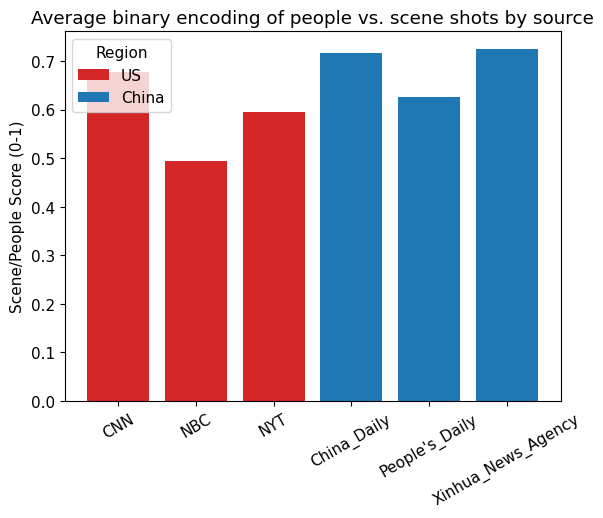

In [ ]:
# collect the average binary encoding (0-1 scenes-people) by source
sources = ['CNN', 'NBC', 'NYT', 'China_Daily', 'People\'s_Daily', 'Xinhua_News_Agency']
data = []

for source in sources:
  data.append(binary_df.groupby('source')['people_count_binary'].mean()[source])

# color the bars by region (US = red, China = blue)
bar_labels = ['US', '_US', '_US', 'China', '_China', '_China']
bar_colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue']

# plot the results
fig, ax = plt.subplots()

ax.bar(sources, data, label=bar_labels, color=bar_colors)
ax.set_ylabel('Scene/People Score (0-1)')
ax.set_title('Average binary encoding of people vs. scene shots by source')
ax.legend(title='Region')
plt.xticks(rotation=30)

plt.show()

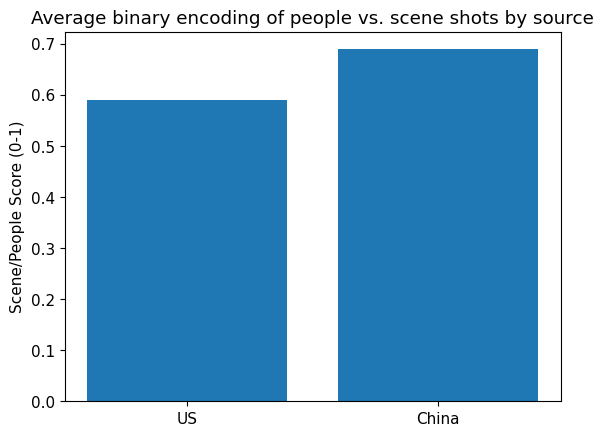

In [ ]:
# collect the average binary encoding (0-1 scenes-people) by region
regions = ['US', 'China']
data = []

for region in regions:
  data.append(binary_df.groupby('region')['people_count_binary'].mean()[region])

# plot the results
fig, ax = plt.subplots()

ax.bar(regions, data)
ax.set_ylabel('Average Scene/People Score (0-1)')
ax.set_title('Average binary encoding of people vs. scene shots by source')

plt.show()

## Triple Encoding (scene, individual, group)

In this section we do the same thing as the previous section except using three categories instead of two, no people (photos with no people in them), individual (photos with exactly one person in them), and group (photos with multiple people in them).

In [ ]:
from collections import defaultdict

# create a copy of the dataframe
tri_df = df.copy()

def def_value():
  return "Group"

encoding_dict = defaultdict(def_value)
encoding_dict[0] = 'No People'
encoding_dict[1] = 'Individual'

# perform triple encoding scheme
tri_df['people_count_triple'] = [encoding_dict[i] for i in tri_df['people_count']]

# group by region
tri_df['region'] = ['US' if i in ['CNN', 'NBC', 'NYT'] else 'China' for i in tri_df['source']]

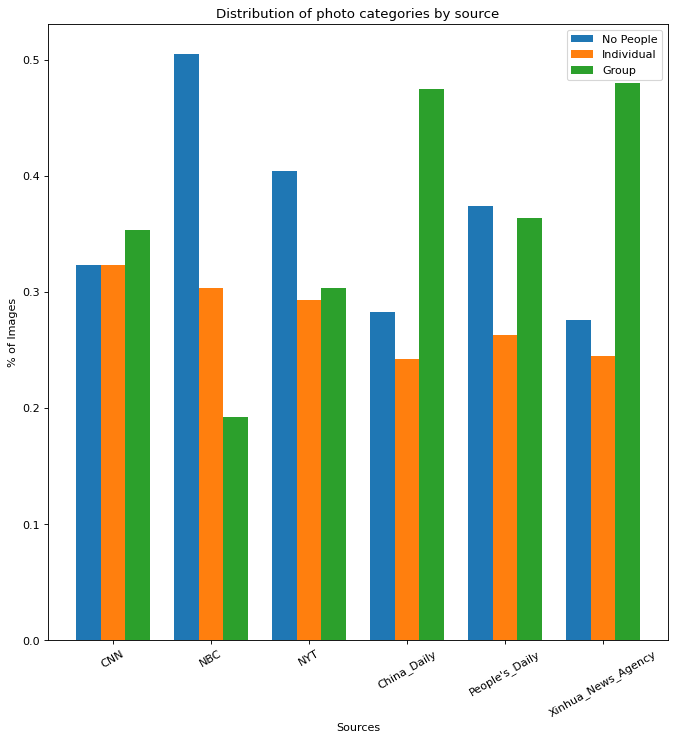

In [ ]:
from matplotlib.pyplot import figure

# list of sources to iterate through
sources = ['CNN', 'NBC', 'NYT', 'China_Daily', 'People\'s_Daily', 'Xinhua_News_Agency']

# dictionary to store values (% of images of each shot)
metrics = {'No People': [], 'Individual': [], 'Group': []}

# iterate through, populating the values
for source in sources:
  for metric in metrics.keys():
    metrics[metric].append(tri_df.groupby(['source'])['people_count_triple'].value_counts(normalize=True)[source][metric])

# plot the results
figure(figsize=(10, 10), dpi=80)

n = 6
ind = np.arange(n)
width = 0.25

xvals = metrics['No People']
bar1 = plt.bar(ind, xvals, width, color = 'tab:blue')

yvals = metrics['Individual']
bar2 = plt.bar(ind+width, yvals, width, color='tab:orange')

zvals = metrics['Group']
bar3 = plt.bar(ind+width*2, zvals, width, color = 'tab:green')

plt.xlabel("Sources")
plt.ylabel('% of Images')
plt.title("Distribution of photo categories by source")

plt.xticks(ind+width, sources, rotation=30)
plt.legend((bar1, bar2, bar3), ('No People', 'Individual', 'Group') )
plt.show()

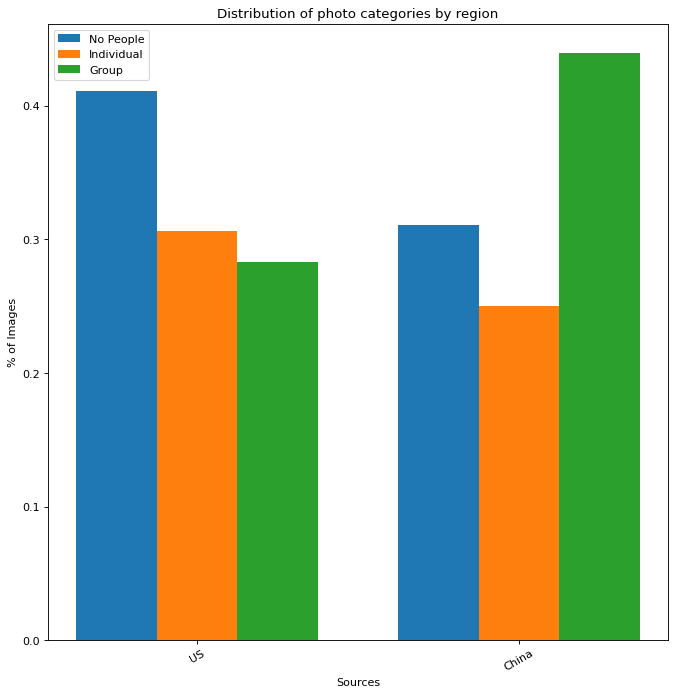

In [ ]:
# same as the above but by region

# list of regions to iterate through
regions = ['US', 'China']

# dictionary to store values (% of images of each shot)
metrics = {'No People': [], 'Individual': [], 'Group': []}

# iterate through, populating the values
for region in regions:
  for metric in metrics.keys():
    metrics[metric].append(tri_df.groupby(['region'])['people_count_triple'].value_counts(normalize=True)[region][metric])

# plot the results
figure(figsize=(10, 10), dpi=80)

n = 2
ind = np.arange(n)
width = 0.25

xvals = metrics['No People']
bar1 = plt.bar(ind, xvals, width, color = 'tab:blue')

yvals = metrics['Individual']
bar2 = plt.bar(ind+width, yvals, width, color='tab:orange')

zvals = metrics['Group']
bar3 = plt.bar(ind+width*2, zvals, width, color = 'tab:green')

plt.xlabel("Sources")
plt.ylabel('% of Images')
plt.title("Distribution of photo categories by region")

plt.xticks(ind+width, regions, rotation=30)
plt.legend((bar1, bar2, bar3), ('No People', 'Individual', 'Group') )
plt.show()

# Classification Model (Decision Tree)

Finally, we use the extracted data to train a classification model to distinguish between US and Chinese sources. We choose to use a decision tree due to its ability to handle categorical on the fly and because it provides some sort of interpretability by examining the structure of the tree, revealing which features were most important/most distinguished between an image from either source.

_

In the investigation, we also experiment using different feature sets to see which are better (for instance hsv vs. lab space, both color and semantic properties or exclusively one of them, etc.). The code below only demonstrates the entire process for training one classification model, to perform the investigation the data sources would need to be modified during setup in the first cell.

In [ ]:
# load the image data

# color data
hsv_df = pd.read_csv('metrics_hsv.csv')

# semantic data
locations_df = pd.read_csv('locations.csv')
people_df = pd.read_csv('people_data-2.csv')

# joining the dataframes together
df = pd.merge(pd.merge(hsv_df, locations_df, on=['source', 'image']), people_df, on=['source', 'image'])
df.dropna(inplace=True)

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# split into train-test (20% for test)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['region', 'source', 'image']), df['region'], test_size=0.2, random_state=42)

# train the model (max_depth=3)
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

# report the accuracy on the test set
print('Accuracy: {}'.format(accuracy_score(y_test, clf.predict(X_test))))

Accuracy: 0.7142857142857143


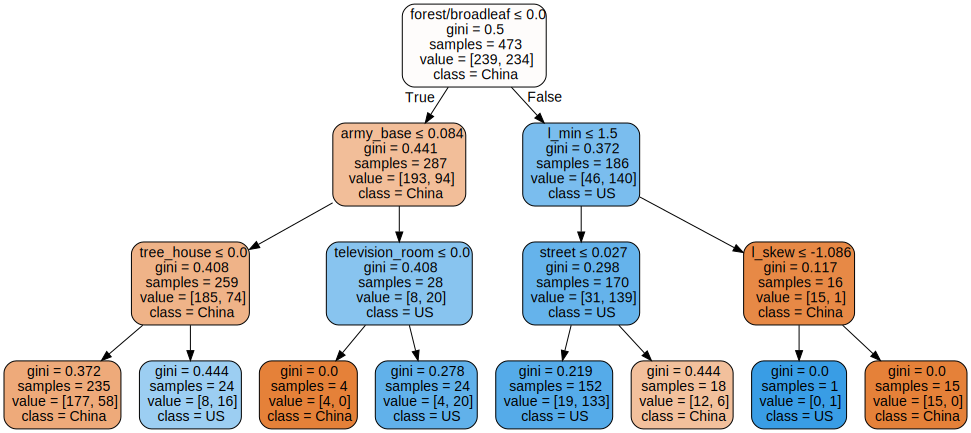

In [ ]:
import graphviz

# visualize the tree
dot_data = tree.export_graphviz(clf,
                  feature_names=list(df.drop(columns=['region', 'source', 'image']).columns),
                  class_names=list(clf.classes_),
                  filled=True, rounded=True,
                  special_characters=True,
                  out_file=None,
                  )

graph = graphviz.Source(dot_data)
graph